# Week 3 - Ungraded Lab: Data Labeling

----------------

Welcome to the ungraded lab for Week 3 of Machine Learning Engineering in Production. In this lab, you will see how the data labeling process affects the performance of a classification model. Labeling data is usually a labor-intensive and costly task, but the model's performance relies on high quality labels.

As you saw in the lectures, there are strategies you can use for labeling data. In the example with the iguanas, you saw three valid labeling strategies that follow different criteria:

<table><tr><td><img src='assets/iguanas1.png'></td><td><img src='assets/iguanas2.png'></td><td><img src='assets/iguanas3.png'></td></tr></table>

**Each labeling strategy is the result of labelers following different rules**. Employing labelers who use different criteria will negatively impact your learning algorithm. Rather, your dataset should have consistent labeling throughout.

In this lab, you will explore how different strategies affect the performance of a machine learning model by simulating the process of having different labelers label the data. You will achieve this effect by performing automatic labeling based on a defined set of rules.

**Your main objective is to understand how labeling affects the performance of machine learning models by comparing performance across labeling options**, including:
1. Randomly generated labels (performance lower bound)
2. Automatic generated labels based on three different labeling strategies
3. True labels (performance upper bound)

Labeling concepts apply to all types of supervised learning, not just computer vision tasks. In this lab, you will work with text data: a dataset containing comments from the 2015 top 5 most popular Youtube videos. Each comment can be classified as `spam` or `not_spam` depending on its content.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Loading the dataset

Begin by cloning the repo that hosts the dataset (not needed if running the notebook on Coursera):

In [3]:
# Uncomment if you're running the notebook outside the Coursera environment
!git clone https://github.com/https-deeplearning-ai/MLEP-public.git

Cloning into 'MLEP-public'...
remote: Enumerating objects: 980, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 980 (delta 67), reused 83 (delta 41), pack-reused 834 (from 1)
Receiving objects: 100% (980/980), 33.33 MiB | 27.06 MiB/s, done.
Resolving deltas: 100% (412/412), done.
Updating files: 100% (130/130), done.


The dataset consists of 5 CSV files, one for each video. You'll use a pandas `DataFrame` to load in the data from the CSV. The following helper function will load the data using pandas:

In [7]:
def load_labeled_spam_dataset():
    """Load labeled spam dataset."""

    # Path where csv files are located
    base_path = "./data"

    # List of csv files with full path
    csv_files = [os.path.join(base_path, csv) for csv in os.listdir(base_path) if ".csv" in csv]

    # List of dataframes for each file
    dfs = [pd.read_csv(filename) for filename in csv_files]

    # Concatenate dataframes into a single one
    df = pd.concat(dfs)

    # Rename columns
    df = df.rename(columns={"CONTENT": "text", "CLASS": "label"})

    # Set a seed for the order of rows
    df = df.sample(frac=1, random_state=423)
    
    return df.reset_index()


# Save the dataframe into the df_labeled variable
df_labeled = load_labeled_spam_dataset()

Inspect the top 5 rows of the `DataFrame` to better understand the dataset's organization:

In [8]:
# Take a look at the first 5 rows
df_labeled.head()

,index,COMMENT_ID,AUTHOR,DATE,text,label
0,329,z132e5zqwlbmjrich234epwa2kiwehdmd,Priscilla Sipinga,2015-01-19T05:53:12.118000,Check out this playlist on YouTube:hbbhhhgh﻿,1
1,255,_2viQ_Qnc69uhVbXr8SjkhLHu7T1HOxqrEF1f6h8vUA,Finuccsi Aka csincsilla3M,2013-09-21T15:43:40.171000,/watch?v=Dtqcftr1Fac JUSTIEN BIEBER CAR 2013. ...,1
2,379,z12gvlyixpjfwrpme23rxfubjvzkvp42s,Toan732,2014-10-31T02:49:34.017000,Ummm... I just hit 1k subscribers. I make Mine...,1
3,2,z12lsjvi3wa5x1vwh04cibeaqnzrevxajw00k,Erica Ross,2014-07-27T02:51:43,Hey guys! Please join me in my fight to help a...,1
4,232,z12rd3vqqsjydb35a04cfxi4kprfxruh5ew,Melissa Harmon,2014-11-07T22:01:04,how is this shit still relevant ﻿,0


In [9]:
df_labeled.shape

(1956, 6)

## Further inspection and preprocessing


### Checking for data imbalance

You may naturally assume that the data you are working on is balanced, meaning that it contains a similar proportion of examples across all classes. Before moving forward, you will test this assumption:

Value counts for each class:

label
1    1005
0     951
Name: count, dtype: int64



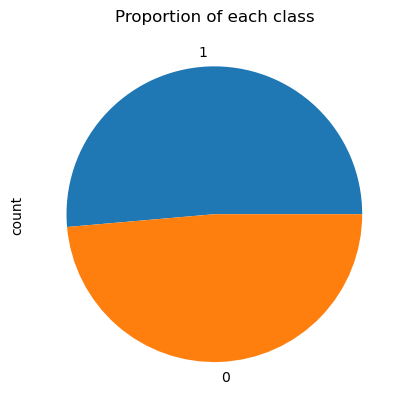

In [10]:
# Print actual value count
print(f"Value counts for each class:\n\n{df_labeled.label.value_counts()}\n")

# Display pie chart to visually check the proportion
df_labeled.label.value_counts().plot.pie(y='label', title='Proportion of each class')
plt.show()

The dataset contains roughly the same number of data points for each class, so class imbalance is not an issue you will need to address.

### Cleaning the dataset

When you inspected the dataset initially, you may have noticed that the `DataFrame` includes information irrelevant to your task. Since you are only interested in the comments, their labels, and the video they belong to, you can drop the remaining columns.

In [11]:
# Drop unused columns
df_labeled = df_labeled.drop(['index', 'COMMENT_ID', 'AUTHOR', 'DATE'], axis=1)

# Look at the cleaned dataset
df_labeled.head()

,text,label
0,Check out this playlist on YouTube:hbbhhhgh﻿,1
1,/watch?v=Dtqcftr1Fac JUSTIEN BIEBER CAR 2013. ...,1
2,Ummm... I just hit 1k subscribers. I make Mine...,1
3,Hey guys! Please join me in my fight to help a...,1
4,how is this shit still relevant ﻿,0


Now the dataset only includes the information you are going to use moving forward.

### Splitting the dataset

Since you will want to later measure the performance of the different models you train, it's a good idea to split the data into train and test sets. As a safety measure, use stratification to maintain the proportion of examples of each class in your split.

In [12]:
from sklearn.model_selection import train_test_split

# Save the text into the X variable
X = df_labeled.drop("label", axis=1)

# Save the true labels into the y variable
y = df_labeled["label"]

# Use 1/5 of the data for testing later
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print number of comments for each set
print(f"There are {X_train.shape[0]} comments for training.")
print(f"There are {X_test.shape[0]} comments for testing")

There are 1564 comments for training.
There are 392 comments for testing


You may want to double check that the stratification worked as expected:

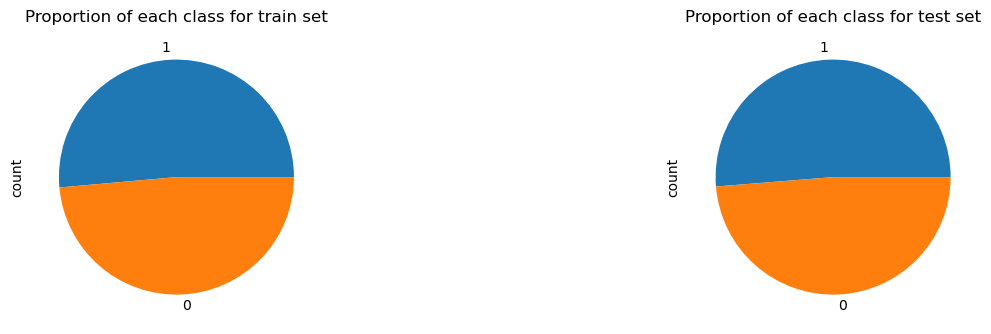

In [13]:
plt.subplot(1, 3, 1)
y_train.value_counts().plot.pie(y='label', title='Proportion of each class for train set', figsize=(10, 6))

plt.subplot(1, 3, 3)
y_test.value_counts().plot.pie(y='label', title='Proportion of each class for test set', figsize=(10, 6))

plt.tight_layout()
plt.show()

Both the train and test sets include a balanced proportion of examples per class. Great! You successfully implemented stratification.

Now you'll start with the data labeling tasks.

## Data Labeling 

### Establishing performance lower and upper bounds for reference

To properly compare different labeling strategies, you need to establish a baseline for model accuracy. In this case, you will establish both a lower and an upper bound to compare different strategies against. 

### Calculate accuracy of a labeling strategy

🔗[CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) is a handy tool included in the `sklearn` ecosystem to encode text-based data.

For more information on working with text data using `sklearn`, check out this 🔗[tutorial](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html).

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

# Allow unigrams and bigrams
vectorizer = CountVectorizer(ngram_range=(1, 5))

Now that the text encoding is defined, you need to select a model to make predictions. For simplicity, you will use a 🔗[Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) classifier. This model is well suited for text classification and is fairly quick to train.

Now you'll define a function to handle the model fitting and print out the accuracy on the test data:

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB


def calculate_accuracy(X_tr, y_tr, X_te=X_test, y_te=y_test, 
                       clf=MultinomialNB(), vectorizer=vectorizer):
    
    # Encode train text
    X_train_vect = vectorizer.fit_transform(X_tr.text.tolist())
    
    # Fit model
    clf.fit(X=X_train_vect, y=y_tr)
    
    # Vectorize test text
    X_test_vect = vectorizer.transform(X_te.text.tolist())
    
    # Make predictions for the test set
    preds = clf.predict(X_test_vect)
    
    # Return accuracy score
    return accuracy_score(preds, y_te)


Next, create a dictionary to store the accuracy of each labeling method:

In [16]:
# Empty dictionary
accs = dict()

### Random Labeling

Generating random labels is a useful technique for establishing a lower bound, since you should expect any viable labeling strategy to outperform random chance. 

Now, calculate the accuracy for the random labeling method:

In [20]:
# Calculate random labels
rnd_labels = np.random.randint(0, 2, X_train.shape[0])

# Feed them alongside X_train to calculate_accuracy function
rnd_acc = calculate_accuracy(X_train, rnd_labels)

rnd_acc

0.5025510204081632

You will see a different accuracy every time you run the previous cell because the labels are determined randomly. Since this is a binary classification problem and both classes are balanced, you can expect to see accuracies around 50%.

Calculate the average accuracy over 10 trials to get a better sense of the base rate:

In [23]:
# Empty list to save accuracies
rnd_accs = []

for _ in range(10):
    # Add every accuracy to the list
    rnd_accs.append(calculate_accuracy(X_train, np.random.randint(0, 2, X_train.shape[0])))

# Save result in accs dictionary
accs['random-labels'] = sum(rnd_accs)/len(rnd_accs)

# Print result
print(f"The random labeling method achieved an accuracy of {accs['random-labels']*100:.2f}%")

The random labeling method achieved an accuracy of 49.97%


Since random labeling completely disregards the information in the solution space and just guesses the correct label, it's difficult to achieve worse accuracy using other strategies. This lower bound serves as reference when comparing other labeling methods. If a certain labeling method doesn't outperform your lower bound, it can be disregarded as a viable option.

### Labeling with true values

Now you'll look at the other end of the spectrum: using the ground truth labels. Retrain your classifier with the actual labels:

In [24]:
# Calculate accuracy when using the true labels
true_acc = calculate_accuracy(X_train, y_train)

# Save the result
accs['true-labels'] = true_acc

print(f"The true labeling method achieved and accuracy of {accs['true-labels']*100:.2f}%")

The true labeling method achieved and accuracy of 91.33%


Training with the true labels produced a noticeable boost in accuracy. This result is expected, as the classifier can now properly identify patterns in the training data which were lacking with randomly generated labels. 

You could achieve higher accuracy by fine-tunning the model or even selecting a different one. For the time being, however, you will keep the model as-is. When trying out different automatic labeling algorithms in the next sections, you'll strive for this ground truth accuracy while holding other aspects of training constant.

## Automatic labeling - Trying out different labeling strategies

Suppose that you don't have access to the true labels for this dataset -- a common situation in machine learning. It's natural to assume that there are patterns in the data that can provide clues about the correct labels. These patterns are dependent on the kind of data you are working with; to even hypothesize which patterns exist usually requires great domain knowledge.

For this particular dataset, you can likely come up with some useful rules that might help distinguish a spam YouTube comment from non-spam. In the following section, you will perform automatic labeling using such rules. **Think of each iteration of this process as a labeler with different criteria for labeling**, and your job is to hire the most promising one.

Notice the word **rules**. To perform automatic labeling, you will define some rules such as "if the comment contains the word 'free', then classify it as spam".

First things first: define how you are going to encode the labeling:
- `SPAM` is represented by 1


- `NOT_SPAM` by 0 


- `NO_LABEL` by -1


You will use the `NO_LABEL` keyword when the rules you come up with don't apply to some data points. In those cases, it is better to avoid giving a label rather than guessing, which you already saw yields poor results.

### First iteration - Define some rules

For this first iteration, you will create three rules based on your intuition about common patterns that appear in spam comments. The rules are simple: classify as SPAM if any of the following patterns is present within the comment, or NO_LABEL otherwise:
- `free` - spam comments usually lure users by promoting free stuff
- `subs` - spam comments tend to ask users to subscribe to some website or channel
- `http` - spam comments include links very frequently

In [25]:
def labeling_rules_1(x):
    
    # Convert text to lowercase
    x = x.lower()
    
    # Define list of rules
    rules = [
        "free" in x,
        "subs" in x,
        "http" in x
    ]
    
    # If the comment falls under any of the rules classify as SPAM
    if any(rules):
        return 1
    
    # Otherwise, NO_LABEL
    return -1

In [26]:
# Apply the rules to the comments in the train set
labels = [labeling_rules_1(label) for label in X_train.text]

# Convert to a numpy array
labels = np.asarray(labels)

# Take a look at the automatic labels
labels

array([-1, -1, -1, ..., -1, -1,  1])

For lots of points, the automatic labeling algorithm decided to not settle for a label, which is expected since this rule only identifies spam comments and can't identify non-spam ones. These points should be deleted, since they don't provide information about the classification process and tend to hurt performance.

In [27]:
# Create the automatic labeled version of X_train by removing points with NO_LABEL label
X_train_al = X_train[labels != -1]

# Remove predictions with NO_LABEL label
labels_al = labels[labels != -1]

print(f"Predictions with concrete label have shape: {labels_al.shape}")

print(f"Proportion of data points kept: {labels_al.shape[0]/labels.shape[0]*100:.2f}%")

Predictions with concrete label have shape: (382,)
Proportion of data points kept: 24.42%


Notice that only 375 data points remained out of the original 1564. The rules defined didn't provide enough context for the labeling algorithm to settle on a label, so around 75% of the data has been trimmed.

Now you'll test the accuracy of the model when using these automatically generated labels:

In [28]:
# Compute accuracy when using these labels
iter_1_acc = calculate_accuracy(X_train_al, labels_al)

# Display accuracy
print(f"First iteration of automatic labeling has an accuracy of {iter_1_acc*100:.2f}%")

# Save the result
accs['first-iteration'] = iter_1_acc

First iteration of automatic labeling has an accuracy of 51.28%


Let's compare this accuracy to the baselines by plotting:

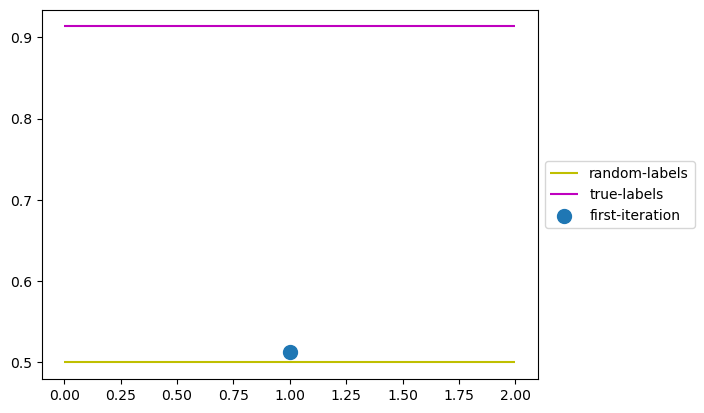

In [29]:
def plot_accuracies(accs=accs):
    colors = list("rgbcmy")
    items_num = len(accs)
    cont = 1

    for x, y in accs.items():
        if x in ['true-labels', 'random-labels', 'true-labels-best-clf']:
            plt.hlines(y, 0, (items_num-2)*2, colors=colors.pop())
        else:
            plt.scatter(cont, y, s=100)
            cont+=2
    plt.legend(accs.keys(), loc="center left",bbox_to_anchor=(1, 0.5))
    plt.show()
    
plot_accuracies()

This first iteration had an accuracy very close to the random labeling, which you should strive to outperform.

Before moving forward, define the `label_given_rules` function that performs all of the steps you just saw: 
- Apply the rules to a dataframe of comments
- Cast the resulting labels to a numpy array
- Delete all data points with NO_LABEL as label
- Calculate the accuracy of the model using the automatic labels
- Save the accuracy for plotting
- Print some useful metrics of the process

In [30]:
def label_given_rules(df, rules_function, name, 
                      accs_dict=accs, verbose=True):
    
    # Apply labeling rules to the comments
    labels = [rules_function(label) for label in df.text]
    
    # Convert to a numpy array
    labels = np.asarray(labels)
    
    # Save initial number of data points
    initial_size = labels.shape[0]
    
    # Trim points with NO_LABEL label
    X_train_al = df[labels != -1]
    labels = labels[labels != -1]
    
    # Save number of data points after trimming
    final_size = labels.shape[0]
    
    # Compute accuracy
    acc = calculate_accuracy(X_train_al, labels)
    
    # Print useful information
    if verbose:
        print(f"Proportion of data points kept: {final_size/initial_size*100:.2f}%\n")
        print(f"{name} labeling has an accuracy of {acc*100:.2f}%\n")
        
    # Save accuracy to accuracies dictionary
    accs_dict[name] = acc
    
    return X_train_al, labels, acc

Moving forward, you will come up with rules that have better coverage of the training data, which makes pattern discovery an easier task. Since the rules were only able to label as either SPAM or NO_LABEL, you will also create some rules that help identify NOT_SPAM comments.

### Second iteration - Coming up with better rules

Inspecting the comments in the dataset more closely, you can distinguish more patterns. For example, NOT_SPAM comments often  references either the number of views (since these were the most watched videos of 2015) or the song in the video and its contents. As for spam comments, other common patterns are to promote gifts or ask to follow some channel or website.

Now, you'll create some new rules that include these patterns:

In [31]:
def labeling_rules_2(x):
    
    # Convert text to lowercase
    x = x.lower()
    
    # Define list of rules to classify as NOT_SPAM
    not_spam_rules = [
        "view" in x,
        "song" in x
    ]
    
    # Define list of rules to classify as SPAM
    spam_rules = [
        "free" in x,
        "subs" in x,
        "gift" in x,
        "follow" in x,
        "http" in x
    ]
    
    # Classify depending on the rules
    if any(not_spam_rules):
        return 0
    
    if any(spam_rules):
        return 1
    
    return -1

This new set of rules looks more promising, as it includes more patterns to classify as SPAM as well as some patterns to classify as NOT_SPAM. These improved rules should result in more data points with a label (as opposed to NO_LABEL).

Check if this is the case.

Proportion of data points kept: 44.37%

second-iteration labeling has an accuracy of 72.45%



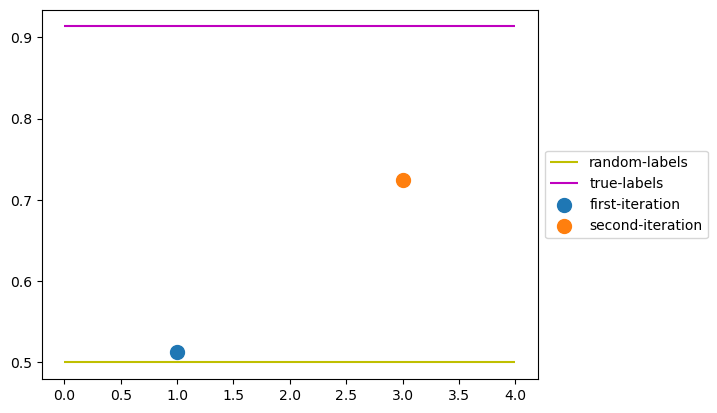

In [32]:
label_given_rules(X_train, labeling_rules_2, "second-iteration")

plot_accuracies()

This time 44% of the original dataset was given a decisive label and there were data points for both labels. This result helped the model reach a higher accuracy compared with the first iteration. Its accuracy is now considerably higher than random labeling, but it is still very far from the upper bound.

Now you'll see if you can make it even better!

### Third Iteration - Even more rules

The rules you have defined so far are doing a fair job. Now, you'll add two additional rules: one each for classifying SPAM and NOT_SPAM comments.

At a glance, it looks like NOT_SPAM comments are usually shorter, possibly because they don't include hyperlinks or because in general they tend to be more concrete (such as "I love this song!").

Take a look at the average number of characters for SPAM comments vs NOT_SPAM ones:

In [33]:
from statistics import mean

print(f"NOT_SPAM comments have an average of {mean([len(t) for t in df_labeled[df_labeled.label==0].text]):.2f} characters.")
print(f"SPAM comments have an average of {mean([len(t) for t in df_labeled[df_labeled.label==1].text]):.2f} characters.")

NOT_SPAM comments have an average of 49.64 characters.
SPAM comments have an average of 137.34 characters.


It sure looks like there is a big difference in the number of characters for both types of comments.

To decide on a threshold to classify as NOT_SPAM, you can plot a histogram of the number of characters in NOT_SPAM comments:

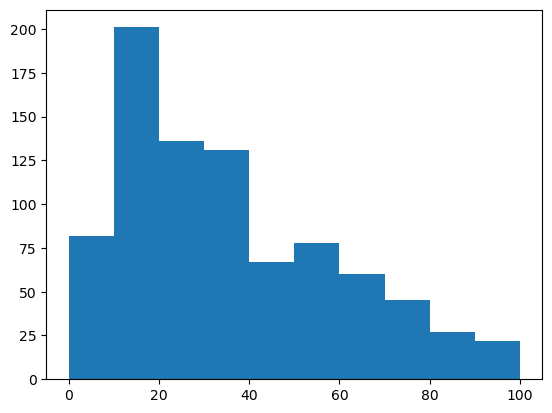

In [34]:
plt.hist([len(t) for t in df_labeled[df_labeled.label==0].text], range=(0,100))
plt.show()

The majority of NOT_SPAM comments have 30 characters or fewer, so you'll use 30 as your threshold.

Another prevalent pattern in spam comments is to ask users to "check out" a channel, website, or link.

Add these two new rules:

In [35]:
def labeling_rules_3(x):
    
    # Convert text to lowercase
    x = x.lower()
    
    # Define list of rules to classify as NOT_SPAM
    not_spam_rules = [
        "view" in x,
        "song" in x,
        len(x) < 30
    ]
    

    # Define list of rules to classify as SPAM
    spam_rules = [
        "free" in x,
        "subs" in x,
        "gift" in x,
        "follow" in x,
        "http" in x,
        "check out" in x
    ]
    
    # Classify depending on the rules
    if any(not_spam_rules):
        return 0
    
    if any(spam_rules):
        return 1
    
    return -1

Proportion of data points kept: 78.07%

third-iteration labeling has an accuracy of 90.31%



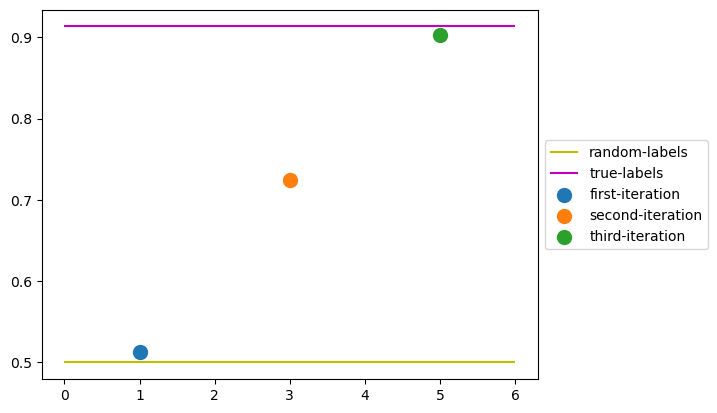

In [36]:
label_given_rules(X_train, labeling_rules_3, "third-iteration")

plot_accuracies()

These new rules do a pretty good job at both SPAM and NOT_SPAM, with good coverage of the dataset and good model accuracy. This labeling strategy reached an accuracy of ~88%! You are getting closer and closer to the upper bound defined by the true labels.

If you're curious, add some more rules to improve accuracy and try them out yourself!

### Come up with your own rules

The following cells contain some code to help you inspect the dataset for patterns and to test out these patterns. The ones used before are commented out in case you want start from scratch or re-use them.

In [40]:
# Configure pandas to print out all rows to check the complete dataset
pd.set_option('display.max_rows', None)

# Check NOT_SPAM comments
df_labeled[df_labeled.label==0].head(10)

,text,label
4,how is this shit still relevant ﻿,0
5,i think about 100 millions of the views come f...,0
8,wow,0
10,"Came here to check the views, goodbye.﻿",0
11,I like it﻿,0
15,"I'm sorry Katy Perry, I was being weird. I sti...",0
17,Charlie from LOST﻿,0
18,Almost a billion﻿,0
21,Oppa! Yeah! Best Song!﻿,0
23,Katty is the best! ! ! ! ﻿,0


In [41]:
# Check SPAM comments
df_labeled[df_labeled.label==1].head(10)

,text,label
0,Check out this playlist on YouTube:hbbhhhgh﻿,1
1,/watch?v=Dtqcftr1Fac JUSTIEN BIEBER CAR 2013. ...,1
2,Ummm... I just hit 1k subscribers. I make Mine...,1
3,Hey guys! Please join me in my fight to help a...,1
6,Check Out LEANDRUS - PLAYTIME It&#39;s awesooo...,1
7,https://www.facebook.com/pages/Nailey-nicool/6...,1
9,this song is so addicting. the hook is dope an...,1
12,IIIIIIIIIII LOVE THIS SHAKE IT SONG OH SORRY E...,1
13,I really love watching football and also I’ve ...,1
14,PLEASE VOTE FOR ME FOR THE WET SEAL MODEL 2015...,1


In [39]:
def your_labeling_rules(x):
    
    # Convert text to lowercase
    x = x.lower()
    
    # Define your rules for classifying as NOT_SPAM
    not_spam_rules = [
#         "view" in x,
#         "song" in x,
#         len(x) < 30
    ]
    

    # Define your rules for classifying as SPAM
    spam_rules = [
#         "free" in x,
#         "subs" in x,
#         "gift" in x,
#         "follow" in x,
#         "http" in x,
#         "check out" in x
    ]
    
    # Classify depending on your rules
    if any(not_spam_rules):
        return 0
    
    if any(spam_rules):
        return 1
    
    return -1


try:
    label_given_rules(X_train, your_labeling_rules, "your-iteration")
    plot_accuracies()
    
except ValueError:
    print("You have not defined any rules.")

You have not defined any rules.


**Congratulations on finishing this ungraded lab!**

By now, you should have a better understanding of the importance of properly labeled data. In general, **the better your labels are, the better your models will be**. The process of correctly labeling data is a very complex one. **Remember, you can think of each one of the iterations of the automatic labeling process to be a different labeler with different criteria for labeling**. If you assume you are hiring labelers, you will want to hire the last one for sure! 

Also keep in mind that establishing baselines will help you evaluate how well your models are performing.

**Keep it up!**